<center><h1>Making Predictions</h1></center>

Acabo de descobrir que a rede treinava com os dados de features e labels desalinhados. Dessa forma, é realmente impossível
aprender algo que faça sentido. =S

Alinhei os dados de entrada e agora estou testando os resultados um por um.

Treinarei com 1 arquivo e compararei com outro

Treinarei com 2 arquivos e compararei com outro

Treinarei com 3 arquivos e compararei com outro

Treinarei com todos os arquivos e compararei com outro.

In [2]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, add, Concatenate, merge, Add,Bidirectional, Activation, concatenate
from keras.models import model_from_json
import pandas as pd
import keras.layers
import keras
import numpy
import numpy as np

### F0 prediction

In [3]:
# load json and create model
json_file = open('f0model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_f0 = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_f0.load_weights("f0model.h5")
print("Loaded model from disk")
 
# compile loaded model with the same parameters
loaded_model_f0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk


In [4]:
# Load data to classify
df1=pd.read_csv("/var/tmp/IA/features/MusicDelta_Reggae_features.csv",header=None)
X=pd.DataFrame.as_matrix(df1)
print (X.shape)

(1089, 513)


In [5]:
# calculate predictions
predictions = loaded_model_f0.predict(X)

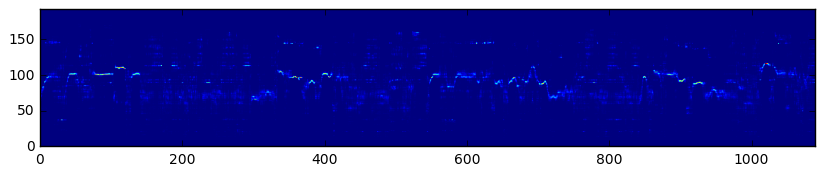

In [54]:
# Plot the grid
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(predictions), origin='lower')
plt.show()

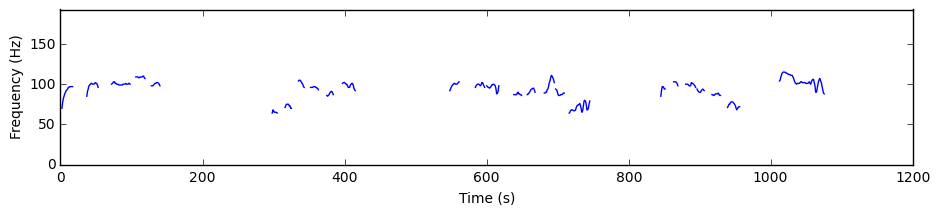

In [9]:
# Get labels to compare
annot = "/var/tmp/IA/labels/MusicDelta_Reggae_labels.csv"

labels = []

with open(annot) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels.append(float(row[0]))
        
for i in range(len(labels)):
    if labels[i] <= 0:
        labels[i] = None
        
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [ ]:
# The comparision is done with the labels precalculated, so it is necessary compare directly.

In [ ]:
# Remove noise from answers
import scipy.signal
ynotes = np.argmax(np.transpose(predictions), axis=0)

In [48]:
# Make the signal smooth (Lower Raw Pitch Accuracy)
ynotes = scipy.signal.medfilt(np.argmax(np.transpose(predictions), axis=0).tolist(), 5)

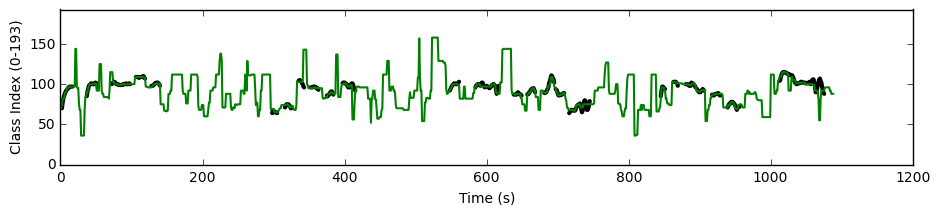

In [68]:
# Plot melodic line from annotation and result
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2], solid_capstyle="round", linewidth=3, color='black')
plt.plot(ynotes, solid_capstyle="round", linewidth=1.5, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

### Measures

In [50]:
# RAW PITCH ACCURACY (error less than a half of a semitone)
# How the classes are done for represent an eight of tone, if the error of estimation
# is in the range {f0-2, f0+2}, the estimation is correct. res = ynotes
lbl = labels[::2]

acc = 0
vstar = 0

for j in range(len(ynotes)):
    if lbl[j] is not None:
        vstar += 1
        if res[j] >= lbl[j]-2 and res[j] <= lbl[j]+2:
            acc += 1
    
print ("Raw Pitch Accuracy:", acc/vstar)    

Raw Pitch Accuracy: 0.80622009569378


### SVDMODEL

In [30]:
# load json and create model
json_file = open('SVDmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_svd = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_svd.load_weights("SVDmodel.h5")
print("Loaded model from disk")

# compile loaded model with the same parameters
loaded_model_svd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk


In [32]:
# Load data to classify
df1 = pd.read_csv("/var/tmp/IA/mfcc/MusicDelta_Reggae_mfcc.csv",header=None)
X = pd.DataFrame.as_matrix(df1)
print (X.shape)

(2177, 120)


In [33]:
# Data Normalization (this step makes me worried =/)
X.max()
X = X - X.mean()
X = X / X.var()**2

X.max()

1513.598610005369

In [35]:
# calculate predictions
voiced = loaded_model_svd.predict(X)
print(voiced)

[[ 0.44754514]
 [ 0.48688793]
 [ 0.48158729]
 ..., 
 [ 0.42143306]
 [ 0.40281123]
 [ 0.39125305]]


In [37]:
# Activation output - need to be 0.5
vcd = voiced.copy()
vcd[vcd <  0.5] = 0
vcd[vcd >= 0.5] = 1

### Measures

In [ ]:
# We have the same value of voiced frames and labeled frames!!!
vocal = vcd

TN, TP, FN, FP = 0, 0, 0, 0

res = vocal.copy()
lbl = labels.copy()

for j in range(len(vocal)):
    if res[j] == 0:
        res[j] = None
        if lbl[j] == res[j]:
            TN += 1
        else:
            FN += 1

    if lbl[j] is not None:
        lbl[j] = 1
        if lbl[j] == res[j]:
            TP += 1
    
    elif res[j] == 1:
        FP += 1

In [69]:
print ("Precision", TP/(TP+FP))
print ("Recall", TP/(TP+FN))
print ("Voicing Recall Rate:", TP/(TP+FN))
print ("Voicing False Alarm Rate:", FP/(TN+FP))  

Precision 0.6966101694915254
Recall 0.4898688915375447
Voicing Recall Rate: 0.4898688915375447
Voicing False Alarm Rate: 0.13378176382660686


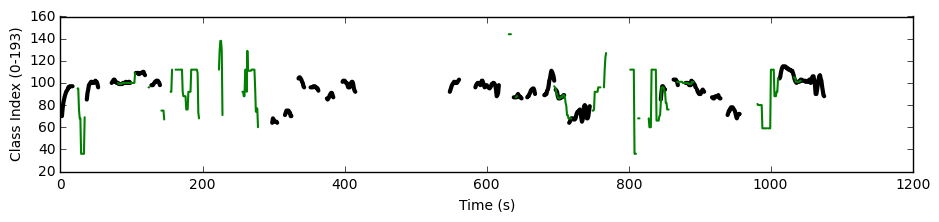

In [67]:
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(lbl, solid_capstyle="round", linewidth=3, color='black')
plt.plot(res, solid_capstyle="round", linewidth=1.5, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

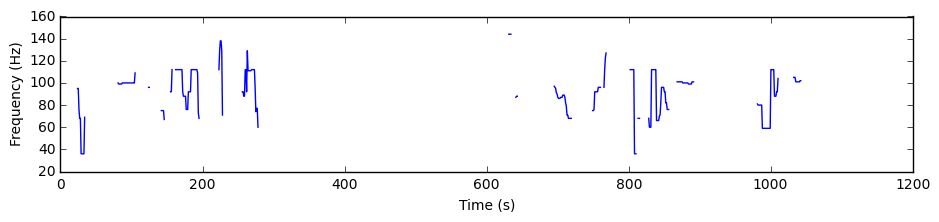

In [56]:
# We have doubled vocal answers
res = []

for j in range(len(ynotes)):
    res.append(int(vocal[j]*float(ynotes[j])))
    if res[j] == 0:
        res[j] = None

# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(res)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()